In [4]:
#! pip install spacy

In [5]:
#! pip install tensorflow

In [6]:
#! python -m spacy download en_core_web_md -q

In [7]:
import pandas as pd
import os
import io
from sklearn.preprocessing import LabelEncoder
import en_core_web_md
from spacy.lang.en.stop_words import STOP_WORDS
from collections import Counter
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
nlp = en_core_web_md.load()

2024-03-18 20:03:25.878872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-18 20:03:26.811974: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Init

In [8]:
df = pd.read_csv('/workspaces/spam/spam.csv', encoding='ISO-8859-1')

In [9]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [10]:
# Initialize the LabelEncoder
le = LabelEncoder()
# Fit label encoder and return encoded labels
encoded_labels = le.fit_transform(df['v1'])
df['encoding'] = encoded_labels

# Pre-processing

 * the command `str.isalnum` remove all characters from your strings that are not alphanumeric except for whitespaces, and apostrophies.
 * using `str.replace`, `str.lower` and `str.strip` replace double whitespaces with single whitespaces, convert all characters to lowercase and trim starting and finishing whitespaces.
 * using spacy, replace all tokens in your texts with `lemma_` and remove all the stop words.

In [11]:
def clean_text(text):
    # Remove specified characters and symbols
    text = re.sub(r"[.,?!;:*&\-'/()]", "", text)  # Remove listed characters
    text = re.sub(r"\b[a-zA-Z]\b", "", text)  # Remove single letters
    text = re.sub(r"\s+", " ", text)  # Replace multiple spaces with a single space
    text = text.lower().strip()
    
    # Lemmatization and removing stopwords
    text = " ".join([token.lemma_ for token in nlp(text) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)])
    
    return text

In [12]:
df["v2_clean"] = df["v2"].apply(clean_text)

Are all the v2_clean the same type?

In [13]:
mask = df.v2_clean.apply(lambda x: type(x)==str)
mask.value_counts()

v2_clean
True    5572
Name: count, dtype: int64

let's check most_common words for more preprocessing and prep for tokenizer steps

In [14]:
words = df['v2_clean'].str.lower().str.split(expand=True).stack()

# Count words
word_count = Counter(words)

# Display the most n common words
print(word_count.most_common(20))

[('2', 480), ('m', 463), ('ur', 380), ('come', 322), ('4', 287), ('know', 283), ('s', 283), ('free', 278), ('ok', 277), ('lt#gt', 276), ('good', 273), ('send', 270), ('like', 252), ('want', 243), ('ill', 237), ('time', 235), ('day', 234), ('"', 232), ('love', 224), ('text', 214)]


In [15]:
specific_words = {'ur', 'come', 'know', 'm', 's', '2', '4', 'lt#gt', '"'}

# Function to remove specific words from a single text
def remove_specific_words(text):
    return " ".join(word for word in text.split() if word not in specific_words)

# Apply this function to each text in the 'v2_clean' column
df['v2_clean'] = df['v2_clean'].apply(remove_specific_words)


# Tokenize v2_clean

In [16]:
# Collect all words into a single list and then create a set to find unique words
unique_words = set(word for message in df.v2_clean for word in message.split())
# Calculate the total number of unique words
total_unique_words = len(unique_words)

In [17]:
total_words = df.v2_clean.apply(lambda x: len(x.split()))
total_words.sum(), total_unique_words

(41064, 8364)

In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=20000, oov_token="out_of_vocab")

In [19]:
#create the index for each words
tokenizer.fit_on_texts(df['v2_clean'])

I am trying to find the best num_words because if set too low some rare words will not be learned by the model

In [20]:
# Tokenizer's learned vocabulary
learned_words = set(tokenizer.word_index.keys())

# Dataset's vocabulary
dataset_words = set(word for text in df['v2_clean'] for word in text.lower().split())

# Find the unique OOV words by comparing the two sets
unique_oov_words = dataset_words - learned_words

print(f"Number of unique out_of_vocab words: {len(unique_oov_words)}")
print(f"Unique out_of_vocab words: {unique_oov_words}")

Number of unique out_of_vocab words: 249
Unique out_of_vocab words: {'16+only', '\\\\', 'ppt150x3+normal', '\\speak', 'everything\\', '@shesil', '+449071512431', '|', '@warner', '<', 'friendship\\', '\\miss', 'said\\if', '~', 'nytec2a3lpmsg@150p', '\\keep', '\\symptoms\\', '\\wylie', '\\our', 'initiate\\', '\\"gud', 'cave\\', 'hello\\', 'today\\', 'iwas+marinethatåõs', '\x89û_thanks', '+447797706009', '\\gette', '\\"this', 'httpalto18coukwavewaveaspo=44345', ']', '\\drink\\', 'crore\\', 'update_now', 'idiot\\', '\\response\\', '\\boost', '\\ah', '\\yeh', '2=', '\\because', '_', 'forever\\', '\\urgent', 'ukp>2000', '\\for', '\\goodmorne', '\\crazy\\', 'week+', 'chrgd@50p', 'late\\', '\\gran', 'frnds\\', '\\"you\\', '\\gimme', '\\woah\\', '50\\', 'mix\\', '>', 'house\\', 'customersqueries@netvisionukcom', '\\er', '\\boo', 'standing|', '88039skilgmetscs087147403231winawkage16+å£150perwksub', '\\alrite', '\\the', 'info@txt82228couk', '\\it', 'silence\\', '\\kudi\\"yarasu', 'padhegm\\', 'xx

In [21]:
df["v2_encoded"] = tokenizer.texts_to_sequences(df['v2_clean'])

# Padding & split (X, y)

In [22]:
df.head()

,v1,v2,encoding,v2_clean,v2_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0,jurong point crazy available bugis great world...,"[3606, 213, 424, 442, 921, 40, 187, 922, 2352,..."
1,ham,Ok lar... Joking wif u oni...,0,ok lar joke wif oni,"[3, 177, 443, 270, 1437]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,free entry wkly comp win fa cup final tkts 21s...,"[2, 283, 510, 642, 22, 1438, 822, 402, 1439, 1..."
3,ham,U dun say so early hor... U c already then say...,0,dun early hor,"[109, 132, 2356]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,nah think usf live,"[683, 14, 643, 114]"


lets make sure all the v2_encoded have the same lenght

In [23]:
X = tf.keras.preprocessing.sequence.pad_sequences(df['v2_encoded'], padding="post")

In [24]:
y = df['encoding']

we have imbalanced -> stratify

In [25]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, stratify=y)

this will help use built in tensorflow method to shuffle and batch for training

In [26]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val = tf.data.Dataset.from_tensor_slices((x_val, y_val))

In [27]:
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [28]:
 # Check one batch
for X, y in train_batch.take(1):
  print(X, y)

tf.Tensor(
[[ 470 1848 1388 ...    0    0    0]
 [ 332   10  140 ...    0    0    0]
 [ 100   75 3722 ...    0    0    0]
 ...
 [  13  176 3774 ...    0    0    0]
 [ 169 4059 2594 ...    0    0    0]
 [  10 2298   15 ...    0    0    0]], shape=(64, 59), dtype=int32) tf.Tensor(
[0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0], shape=(64,), dtype=int64)


2024-03-18 20:03:59.165422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# model

In [29]:
# this is the number of words set up by my tokenizer
num_words = tokenizer.num_words
num_words

20000

In [30]:
#X = tf.keras.preprocessing.sequence.pad_sequences(df['v2_encoded'], padding="post")
input_shape = X.shape[1]
input_shape

59

In [31]:
model = tf.keras.Sequential([
                  tf.keras.layers.Embedding(num_words+1, 16, input_shape=[input_shape,], name="embedding"),
                  tf.keras.layers.GlobalAveragePooling1D(),
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(1, activation="sigmoid")
])

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 59, 16)         │       320,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320,305 (1.22 MB)

 Trainable params: 320,305 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [33]:
optimizer= tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(), 
                       tf.keras.metrics.Recall()])

In [34]:
history = model.fit(train_batch, 
                    epochs=20,
                    validation_data=val_batch)

Epoch 1/20


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8094 - loss: 0.4662 - precision: 0.1562 - recall: 0.0819 - val_accuracy: 0.8660 - val_loss: 0.3660 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8632 - loss: 0.3637 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8660 - val_loss: 0.3470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8752 - loss: 0.3369 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8660 - val_loss: 0.3499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8609 - loss: 0.3578 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.8660 - val_loss: 0.3470 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8659 - loss: 0.3430 - precision: 0.0000e+00 - recall: 0.000

# Save DF, Model & Tokenizer

In [39]:
#df.to_csv('/workspaces/spam/df.csv', index=False)

In [37]:
# Save your trained model
#model.save('16D_20epochs.keras')

In [40]:
# import pickle
# with open('/workspaces/spam/tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Plot eval

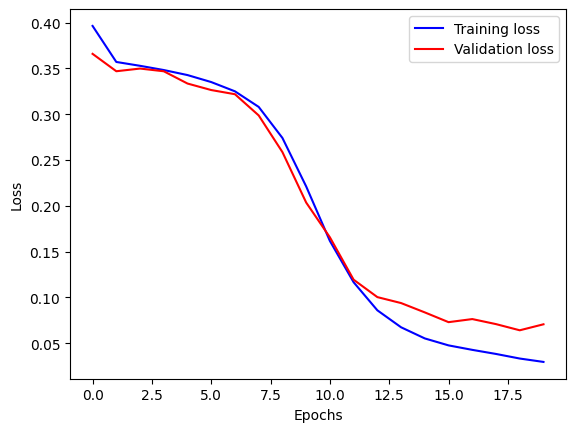

In [36]:
# Visualization of the training process on the loss function
plt.plot(history.history["loss"], color="b", label="Training loss")
plt.plot(history.history["val_loss"], color="r", label="Validation loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(loc="best")
plt.show()

# Embeddings projector for our custom tokenizer

In [ ]:
vocab = [value for value in tokenizer.index_word.values()]
vocab = vocab[:1000]
weights = model.get_layer('embedding').get_weights()[0]

log_dir = "/workspaces/spam"
os.makedirs(log_dir, exist_ok=True)
out_v = io.open(log_dir+"/vectors.tsv", 'w', encoding='utf-8')
out_m = io.open(log_dir+"/metadata.tsv", 'w', encoding='utf-8')

for index, word in enumerate(vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()